Imports

In [2]:
import numpy as np
import scipy.signal as sig
from matplotlib import pyplot as plt 
import random
import librosa

Functions

In [3]:
# ------------------ VVVVVVV THIS IS THE FUNCTION TO USE --------------------------- # 

# Takes in pixel and returns spike train
def rateCodingRandPix2Spike(pVal,tu):
    spikeTrain = [ int(1) if pVal > random.random() else int(-1) if -1*pVal > random.random()  else int(0) for i in range(tu)]
    return np.asarray(spikeTrain)

# # Normalizes 2d image between 0 and 1
# def norm2D(image):
#     return (image - np.min(image)) / (np.max(image) - np.min(image))

def rateCodingRand2D(signal):
    # 1. Normalize the input image
    image = signal/np.max(signal)
    # 2. Set a firing rate, T
    T = 1  # Set to spike train interval 100ms
    # 3. Using T obtain time axis 
    dt = 1  # (T = 100ms -> dt = 1000ms/100 = 1ms)
    bins = int(T / dt)  # time axis length of 100 units
    # random.seed(9)
    # 4. For each normalized pixel value in , pVal, in image and for each 
    # time unit T, generate a random number, r from range (0,1). 
    # If pVal > r then store a spike at that time instant otherwise 0.
    spikeTrainOut = 0
    for x in image:
        spikeTrain = rateCodingRandPix2Spike(x,bins)
        # print('Normal val',x,'fired on',(len([i for i in spikeTrain if i == 1]))/bins,'%')
        spikeTrainOut = np.hstack((spikeTrainOut, spikeTrain))

    return spikeTrainOut



def calc_spike_train(time, signal):

    del_t = 0.0

    spike_train = np.zeros(np.size(time))

    for i in range(np.size(time)):
        
        r = random.random()

        if signal[i] > 0 and signal[i] > r + del_t :
            spike_train[i] = 1

        elif signal[i] < 0 and -1*signal[i] > r:
            spike_train[i] = -1

        else: spike_train[i] = 0

    return spike_train


def generate_multi_sine_wave(duration, frequencies, amplitudes, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate)
    signal = np.sum([amplitude * np.sin(2 * np.pi * frequency * t) for frequency, amplitude in zip(frequencies, amplitudes)], axis=0)
    return t, signal


Signal

In [4]:
# Parameters
duration = 1  # seconds
frequencies = [2500]  # Hz
amplitudes = [1]
sampling_rate = 44100  # Hz

time, signal = generate_multi_sine_wave(duration, frequencies, amplitudes, sampling_rate)

spk_trn = calc_spike_train(time, signal)

spk_trn2 = rateCodingRand2D(signal)

# Building blocks for the low pass filter

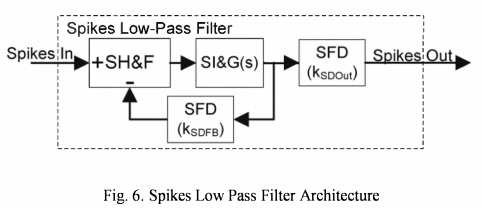

## Spike hold and fire

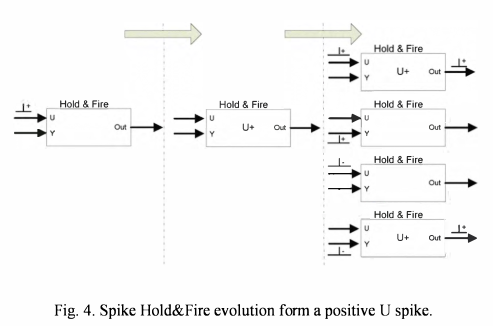

In [5]:

# A class for the Spike Hold and Fire block

class SHaF:
    def __init__(self):
        self.U = 0
        self.Y = 0
        self.state = ""
        self.current_out = 0

    def input(self, u = 0, y = 0):
        self.U = u
        self.Y = y

    def output(self):
        return self.current_out


    def calculate(self):

        match self.state:
            case "Up":
                if self.U == 1:
                    self.state = "Up"
                    self.current_out = 1
          

                elif self.Y == 1:
                    self.state = ""
                    self.current_out = 0
   
                    
                elif self.U == -1:
                    self.state = ""
                    self.current_out = 0
         

                elif self.Y == -1:
                    self.state = "Up"
                    self.current_out = 1
             
            case "Un":

                if self.U == 1:
                    self.state = ""
                    self.current_out = 0
           

                elif self.Y == 1:
                    self.state = "Un"
                    self.current_out = -1
             

                elif self.U == -1:
                    self.state = "Un"
                    self.current_out = -1
             
                
                elif self.Y == -1:
                    self.state = ""
                    self.current_out = 0
              
        
            case "Yp":

                if self.U == 1:
                    self.state = ""
                    self.current_out = 0
                    

                elif self.Y == 1:
                    self.state = "Yp"
                    self.current_out = 1

                elif self.U == -1:
                    self.state = "Yp"
                    self.current_out = 1
                
                elif self.Y == -1:
                    self.state = ""
                    self.current_out = 0
        
            case "Yn":

                if self.U == 1:
                    self.state = "Yn"
                    self.current_out = -1

                elif self.Y == 1:
                    self.state = ""
                    self.current_out = 0
                    
                elif self.U == -1:
                    self.state = ""
                    self.current_out = 0
                    

                elif self.Y == -1:
                    self.state = "Yn"
                    self.current_out = -1
                
            case "":
                if self.U == 1:
                    self.state = "Up"
                    self.current_out = 0
                
                elif self.U == -1:
                    self.state = "Un"
                    self.current_out = 0

                elif self.Y == 1:
                    self.state = "Yp"
                    self.current_out = 0

                elif self.Y == -1:
                    self.state = "Yn"
                    self.current_out = 0


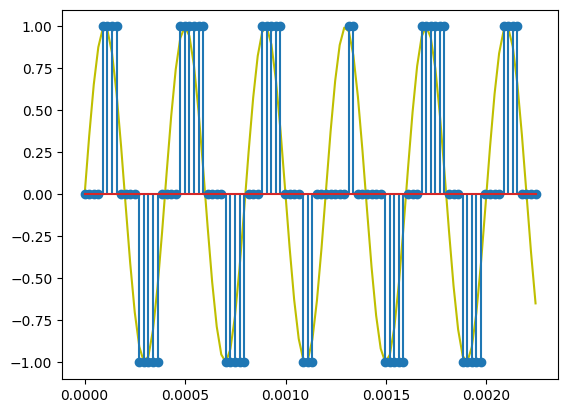

In [6]:
shf1 = SHaF()

output_train = []

# First SLPF
for spk in spk_trn2:
    shf1.U = spk
    shf1.calculate()
    past_out = shf1.current_out
    output_train = np.append(output_train, past_out)
    shf1.Y = past_out

plt.plot(time[:100], signal[:100], color="y");
plt.stem(time[:100], output_train[:100]);

# The original analog signal plotted with the spike train AFTER the first SH&F block

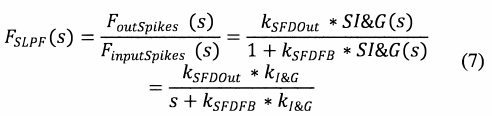

Formula for determining the output frequency of the SLPF

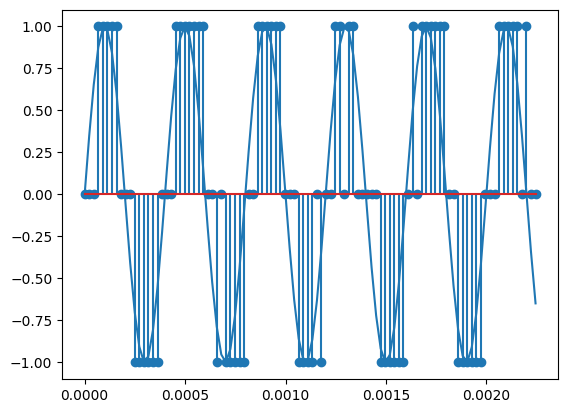

In [7]:
plt.plot(time[:100], signal[:100]);
plt.stem(time[:100], spk_trn2[:100]);

# THe original signal plotted with the generated spike train

3596


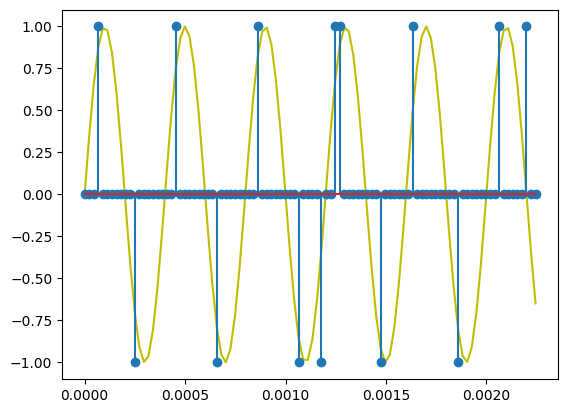

In [8]:
slpf1 = spk_trn2 - output_train 

plt.plot(time[:100], signal[:100], color="y")

plt.stem(time[:100], slpf1[:100])

pos_spikes = np.sum(slpf1 > 0)
print(pos_spikes)

# The original signal plotted with the output of the first SH&F block. This is the spike rate which should correspond to the frequency in the signal

## Spike Integrate and generate

The SH&F is not enough, I need at least another block to be able to tune the filtering of all the needed filters

In [9]:
class SIaG:

    def __init__(self, spike_threshold:int ):
        self.spikes_Count = 0
        self.spike_threshold = spike_threshold
    
    def process_spike(self, spike):

        self.spikes_Count += spike

        if self.spikes_Count > 0 and self.spikes_Count >= self.spike_threshold:
            
            self.spikes_Count = 0

            return 1
        
        elif self.spikes_Count < 0 and self.spikes_Count <= -1 * self.spike_threshold:
            
            self.spikes_Count = 0

            return -1
        
        else: return 0


    def calc_train(self, spike_train):

        output_train = []

        for s in spike_train:
            res = self.process_spike(s)

            output_train = np.append(output_train, res)

        return output_train


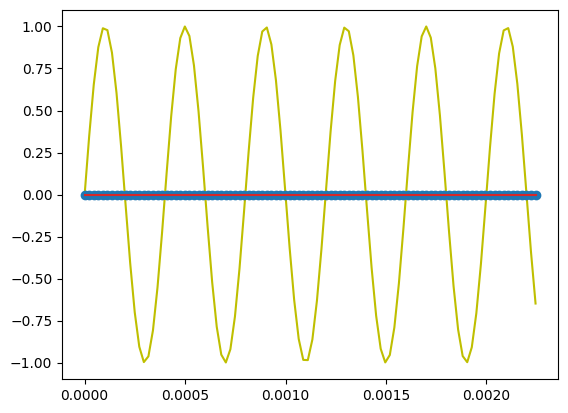

In [10]:
siag1 = SIaG(spike_threshold=17)

siag1_out = siag1.calc_train(output_train)

plt.plot(time[:100], signal[:100], color="y");
plt.stem(time[:100], siag1_out[:100]);


# Test with current knowledge

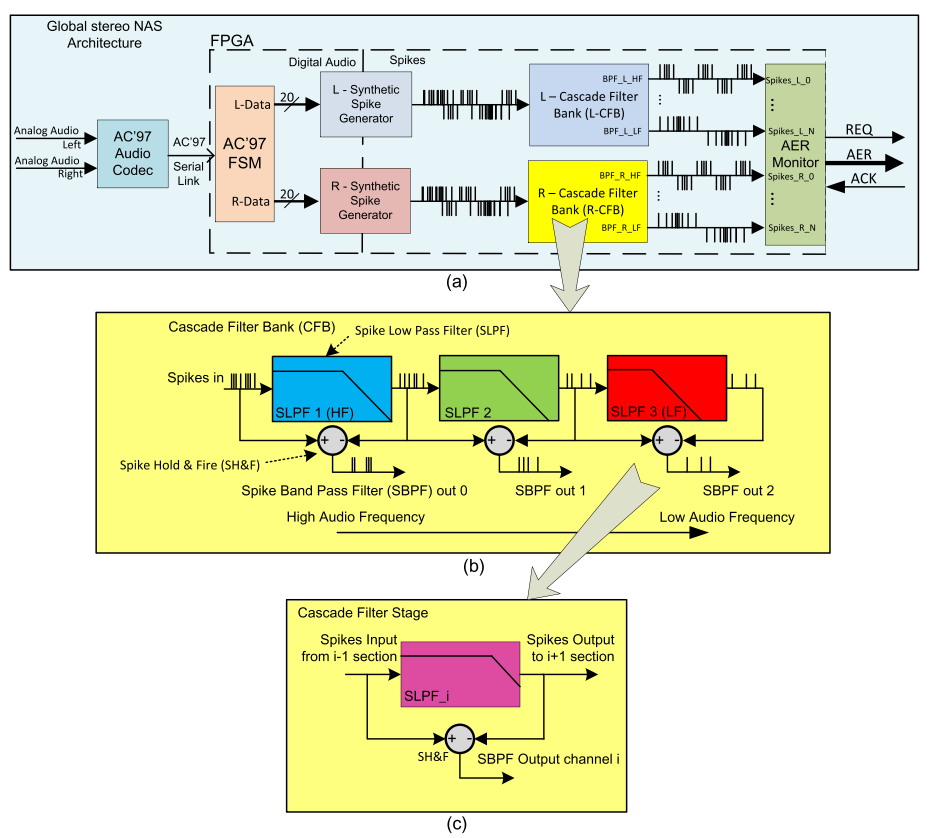

A Binaural Neuromorphic Auditory sensor for FPGA... 2018

Each SLPF should receive a spike train, output all the spikes being passed by the filter,  
and then have the difference between the in- and output be the perceived activity in the given frequency band

#### SLPF Class and SFD Class

In [11]:
class SFD():

    def __init__(self, t) -> None:
        
        self.counter = 0
        self.past_spike = 0
        self.threshold = t


    def count_and_divide(self, spike):

        if spike != 0:
            self.counter += 1

        if self.counter >= self.threshold:
            None


In [12]:
class SLPF():

    def __init__(self, thres) -> None:

        self.HaF_internal = SHaF()
        self.HaF_activity = SHaF()

        self.IaG_internal = SIaG(spike_threshold=thres)

        self.output_train = []
        self.activity_train = []

    
    def process_spikes(self, spk_trn):

        # Internals

        for spk in spk_trn:
            self.HaF_internal.U = spk                   # Input spike is defined
            self.HaF_internal.calculate()               # The state of the block and the subsequent output is calculated

            spike_out = self.IaG_internal.process_spike(self.HaF_internal.current_out)    # The SI&G step is handled

            # spike_out = self.HaF_internal.current_out

            self.output_train = np.append(self.output_train, spike_out)               # The resulting output of the two blocks is added to the new spiking train
            
            self.HaF_internal.Y = spike_out                                 # The calculated output is given to the SHaF as feedback input

            
            self.HaF_activity.U = spk
            self.HaF_activity.Y = spike_out           

            self.HaF_activity.calculate()

            activity_out = self.HaF_activity.current_out

            self.activity_train = np.append(self.activity_train, activity_out)

            
class SLPF2(): # SPIKE BY SPIKE

    def __init__(self, thres) -> None:

        self.HaF_internal = SHaF()
        self.HaF_activity = SHaF()

        self.IaG_internal = SIaG(spike_threshold=thres)

    
    def process_spike(self, spk):

        # Internals

        
        self.HaF_internal.U = spk                   # Input spike is defined
        self.HaF_internal.calculate()               # The state of the block and the subsequent output is calculated

        spike_out = self.IaG_internal.process_spike(self.HaF_internal.current_out)    # The SI&G step is handled

        # spike_out = self.HaF_internal.current_out

        
        self.HaF_internal.Y = spike_out                                 # The calculated output is given to the SHaF as feedback input

        
        self.HaF_activity.U = spk
        self.HaF_activity.Y = spike_out      

        self.HaF_activity.calculate()

        activity_out = self.HaF_activity.current_out


        return spike_out, activity_out


## Example

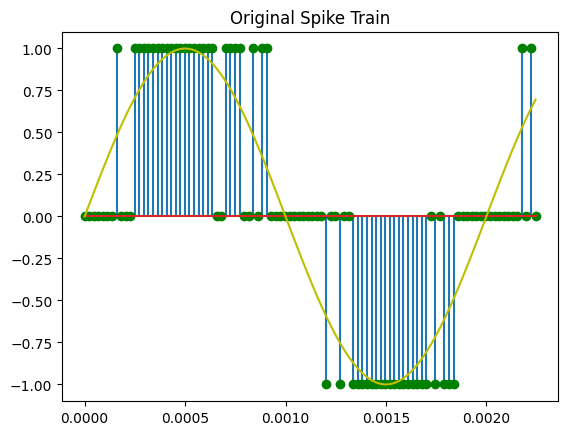

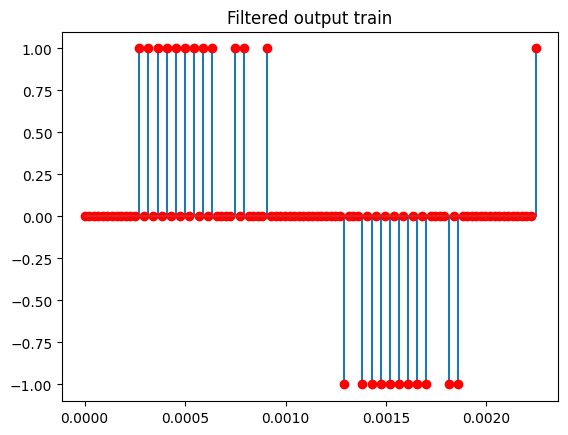

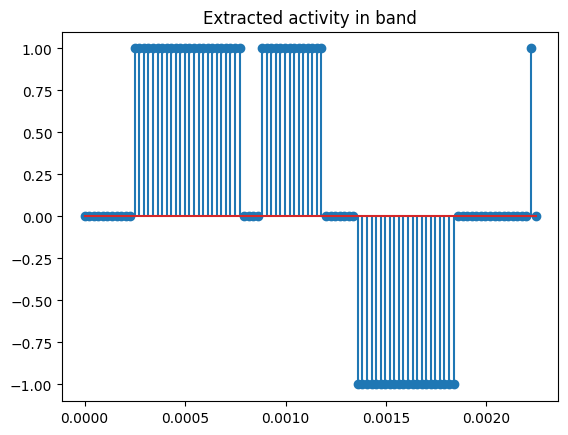

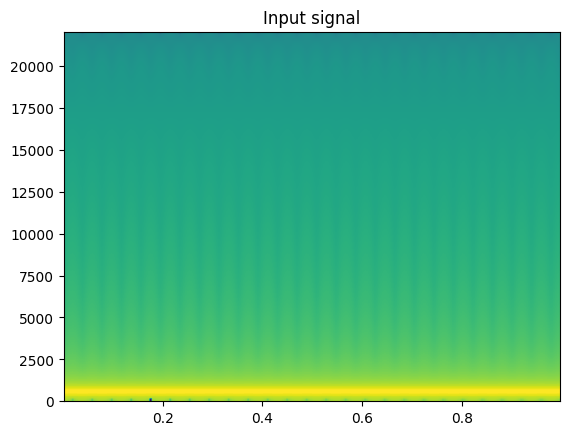

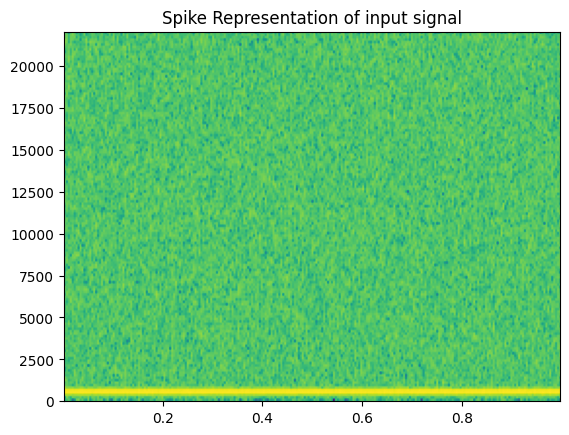

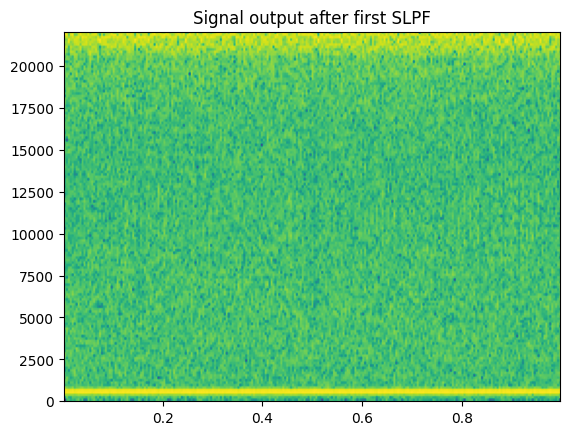

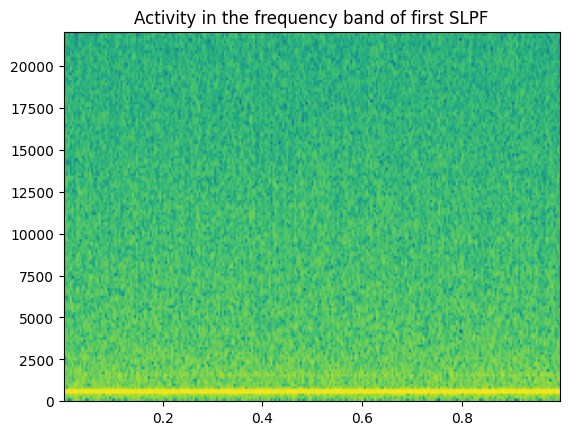

In [13]:
# Parameters
duration = 1  # seconds
frequencies = [500, 15000]  # Hz
amplitudes = [1,0]
sampling_rate = 44100  # Hz

time, signal = generate_multi_sine_wave(duration, frequencies, amplitudes, sampling_rate)

# signal = signal + sig.chirp(time, 20, 1, 22000)


spk_trn = rateCodingRand2D(signal) # Signal is being translated into a spike train based on a spiking chance for each time interval given by the value of the signal


### ------------- PROCESSING ENTIRE TRAIN -------------- ###

# SLPF_1 = SLPF(thres=3)

# SLPF_1.process_spikes(spk_trn=spk_trn)

# slpf1_out = SLPF_1.activity_train
# output_train = SLPF_1.output_train


### ------------- PROCESSING SPIKE BY SPIKE -------------- ###
slpf1_out = []
output_train = []

SLPF_2 = SLPF2(thres=2)

for s in spk_trn:
    so, ao = SLPF_2.process_spike(s)
    slpf1_out = np.append(slpf1_out, ao)
    output_train = np.append(output_train, so)



# Plotting

interval = 100
plt.stem(time[:interval], spk_trn[:interval], markerfmt="go")
plt.plot(time[:interval], signal[:interval], color="y")
plt.title("Original Spike Train")
plt.show()

plt.stem(time[:interval], output_train[:interval], markerfmt="ro")
plt.title("Filtered output train")
plt.show()

plt.stem(time[:interval], slpf1_out[:interval])
plt.title("Extracted activity in band")
plt.show()


# Spectograms

plt.specgram(signal, 300, Fs=44100, scale='dB');
plt.title("Input signal")
plt.show()

plt.specgram(spk_trn, 300, Fs=44100, scale='dB');
plt.title("Spike Representation of input signal")
plt.show()

plt.specgram(output_train, 300, Fs=44100, scale='dB');
plt.title("Signal output after first SLPF")
plt.show()

plt.specgram(slpf1_out, 300, Fs=44100, scale='dB');
plt.title("Activity in the frequency band of first SLPF")
plt.show()


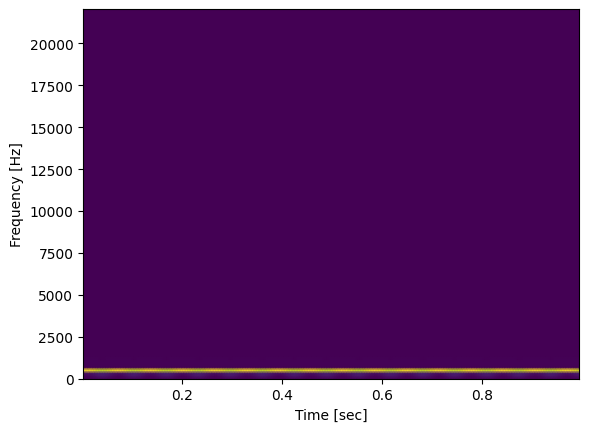

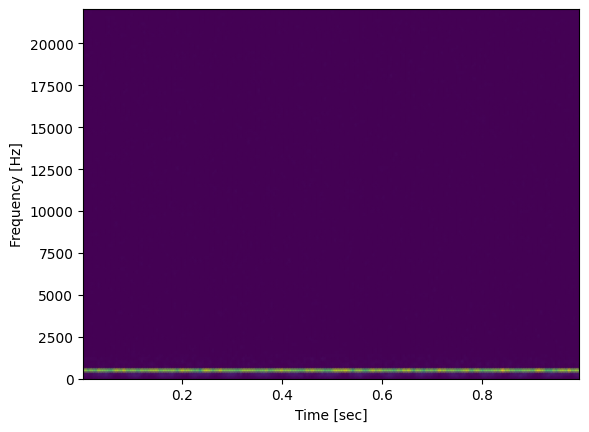

In [14]:
f, t, Sxx = sig.spectrogram(signal, sampling_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Sxx = sig.spectrogram(spk_trn, sampling_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

SFD TEST

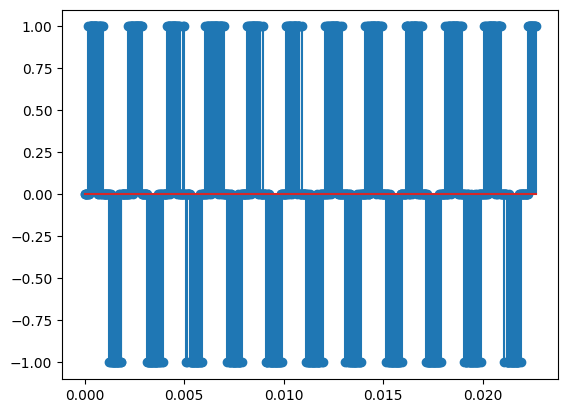

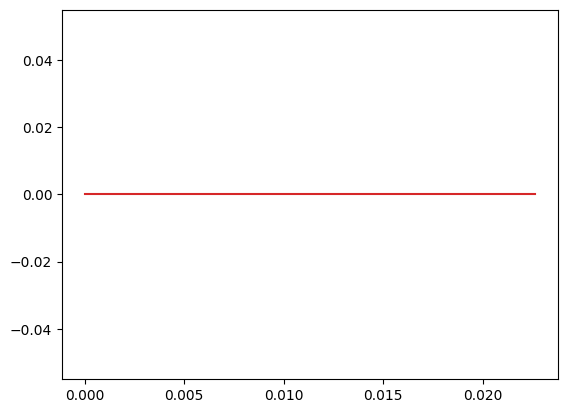

In [15]:
sfd1 = SFD(t=2)

s2 = []

for i in spk_trn:
    spike_result = sfd1.count_and_divide(i)

    s2 = np.append(s2, spike_result)

plt.stem(time[:1000], spk_trn[:1000])
plt.show()

plt.stem(time[:1000], s2[:1000])
plt.show()

